# Matlab Model Sync

## Control Allocation (Unknown)

Systematically testing each aspect of the Python/Matlab UAV models to ensure they match as close as possible

In [97]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from copy import deepcopy

from multirotor.coords import body_to_inertial, direction_cosine_matrix, inertial_to_body, rotating_frame_derivative
from multirotor.vehicle import BatteryParams, MotorParams, PropellerParams, VehicleParams, SimulationParams
from multirotor.helpers import control_allocation_matrix

In [98]:
scenarios = ['nominal']
modes = ['python', 'matlab']

scenario = scenarios[0]
mode = modes[1]

In [99]:
# importing from matlab
alloc_in = pd.read_csv(f'../data/allocation_in.csv')
alloc_in = np.array(alloc_in)
motor_speeds = pd.read_csv(f'../data/motorref.csv')
motor_speeds = np.array(motor_speeds)

In [100]:
BP = BatteryParams(max_voltage=22.2)
MP = MotorParams(
    moment_of_inertia=5e-5,
    resistance=0.27,
    # resistance=0.081,
    k_emf=0.0265,
    k_motor=0.0932,
    speed_voltage_scaling=0.0347,
    max_current=38.
)
PP = PropellerParams(
    moment_of_inertia=1.86e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=MP
    # motor=None
)
VP = VehicleParams(
    propellers=[deepcopy(PP) for _ in range(8)],
    battery=BP,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.375 * np.pi, # np.pi / 2
    # angles=np.linspace(0, -2*np.pi, num=8, endpoint=False),
    distances=np.ones(8) * 0.635,
    clockwise=[-1,1,-1,1,-1,1,-1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2506, 0, 0],
        [0, 0.2506, 0.],
        [0, 0, 0.4538]
    ])
)
SP = SimulationParams(dt=0.01, g=9.81, dtype=np.float32)

alloc, alloc_inverse = control_allocation_matrix(VP)

In [101]:
def allocate_control(thrust: float, torques: np.ndarray) -> np.ndarray:
        """
        Allocate control to propellers by converting prescribed forces and torqes
        into propeller speeds. Uses the control allocation matrix.

        Parameters
        ----------
        thrust : float
            The thrust in the body z-direction.
        torques : np.ndarray
            The roll, pitch, yaw torques required about (x, y, z) axes.

        Returns
        -------
        np.ndarray
            The prescribed propeller speeds (rad /s)
        """
        # # TODO: njit it? np.linalg.lstsq can be compiled
        vec = np.asarray([thrust, *torques], np.float32)
        # return np.sqrt(np.linalg.lstsq(self.alloc, vec, rcond=None)[0])
        return np.sqrt(
            np.clip(alloc_inverse @ vec, a_min=0., a_max=None)
        )

def allocate_control_matlab(thrust: float, torques: np.ndarray) -> np.ndarray:
        """
        Allocate control to propellers by converting prescribed forces and torqes
        into propeller speeds. Uses the control allocation matrix.

        Parameters
        ----------
        thrust : float
            The thrust in the body z-direction.
        torques : np.ndarray
            The roll, pitch, yaw torques required about (x, y, z) axes.

        Returns
        -------
        np.ndarray
            The prescribed propeller speeds (rad /s)
        """
        l=0.635
        b=9.8419e-05
        d=1.8503e-06

        angsm = np.cos(np.pi/8)
        anglg = np.cos(3*np.pi/8)
        
        A_f = np.array([[b, b, b, b, b, b, b, b],
                       [-b*l*anglg, -b*l*angsm, b*l*angsm, b*l*anglg, b*l*anglg, b*l*angsm, -b*l*angsm, -b*l*anglg],
                       [-b*l*angsm, -b*l*anglg, -b*l*anglg, -b*l*angsm, b*l*angsm, b*l*anglg, b*l*anglg, b*l*angsm],
                       [d, -d, d, -d, d, -d, d, -d]], dtype=np.float32)
        
        u_des = np.array([thrust, torques[0], torques[1], torques[2]], dtype=np.float32)
        
        a = np.linalg.pinv(A_f)
        Omega_s = np.linalg.pinv(A_f) @ np.expand_dims(u_des, 1)
        
        wref = np.zeros(8)
        for i in range(len(Omega_s)):
            if Omega_s[i] < 0:
                wref[i] = 0
            elif Omega_s[i] > 670**2:
                wref[i] = 670
            else:
                wref[i] = np.sqrt(Omega_s[i])
        
        return np.round(wref, 1)

def simulate_ft_calc(alloc_in):
    force = alloc_in[:,0]
    torques = alloc_in[:,1:4]
    log = []

    for f, t in zip(force, torques):
        if mode == 'python':
            wref = allocate_control(f, t)
        elif mode == 'matlab':
            wref = allocate_control_matlab(f, t)
        
        log.append(wref)

    return np.array(log)

In [102]:
log = simulate_ft_calc(alloc_in)

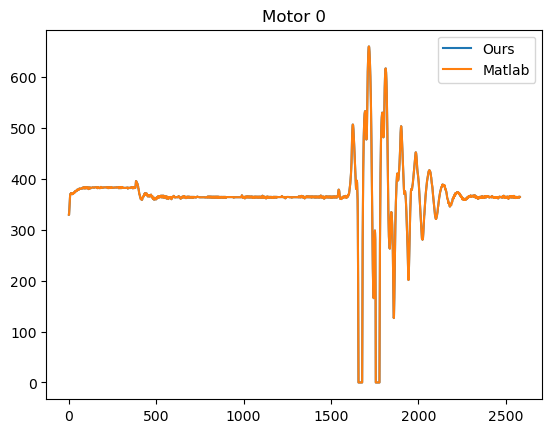

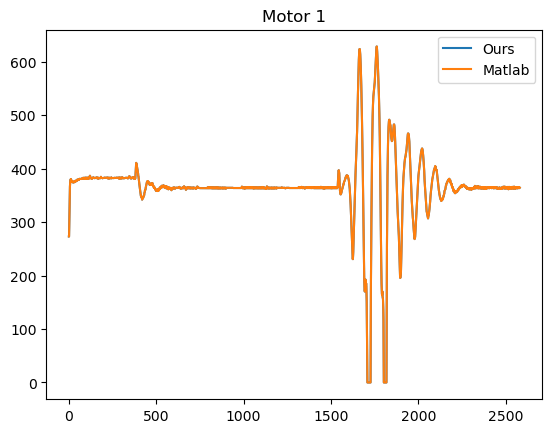

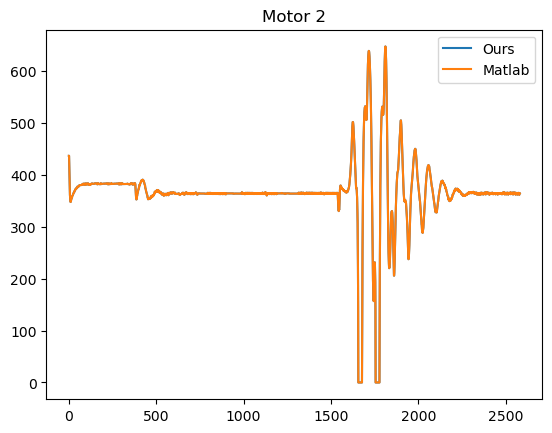

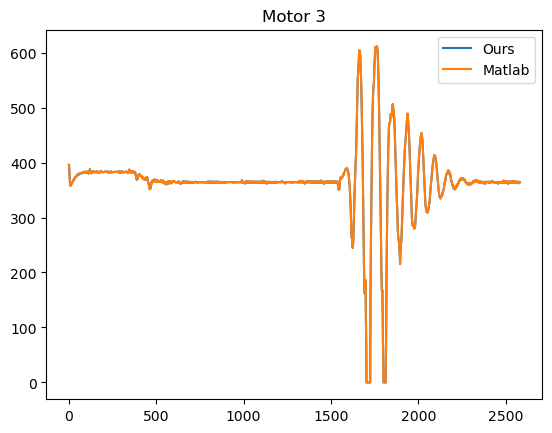

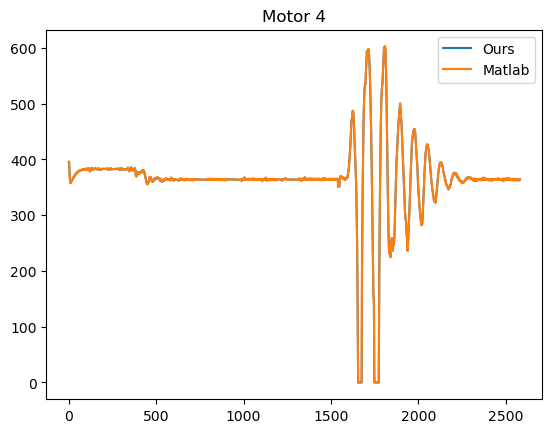

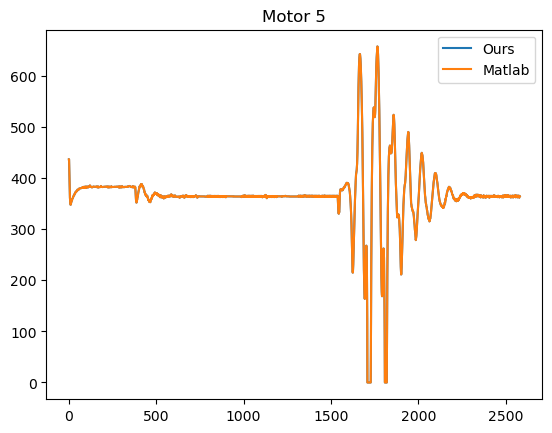

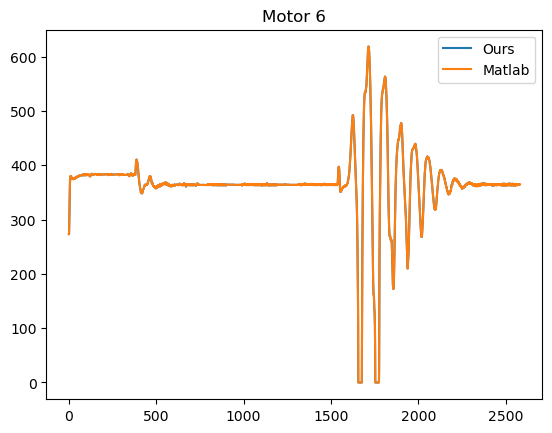

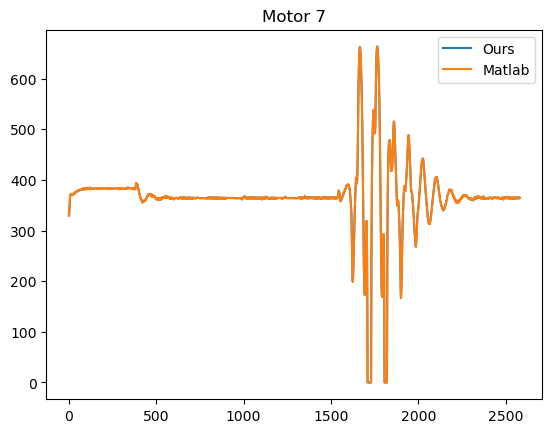

In [103]:
for i in range(8):
    plt.plot(log[:,i], label='Ours')
    plt.plot(motor_speeds[:,i], label='Matlab')
    plt.title(f"Motor {i}")
    plt.legend()
    plt.show()